# Market Making (RL)

*In this notebook, we will implement a simple market making strategy using reinforcement learning. The goal of the market maker is to maximize the profit by providing liquidity to the market. The market maker will place two limit orders, one buy order and one sell order, around the mid price. The market maker will adjust the price of the limit orders based on the current inventory and the recent price movements. The market maker will also adjust the size of the limit orders based on the current inventory and the recent price movements. The market maker will use reinforcement learning to learn the optimal price and size of the limit orders.*

## Setup

In [18]:
# Data loading and preprocessing
from utils.load_data import load_data
from utils.evaluate import evaluate_strategy, get_pnl

# Environment
from environment.env import Real_Data_Env

# Model
from strategies.rl import QLearning, RLStrategy, SARSA
from strategies.baselines import BestPosStrategy, StoikovStrategy


import numpy as np
import random

np.random.seed(134251)
random.seed(134251)

## Data Preparation
The data used for this notebook is the [Crypto Lake website](https://crypto-lake.com/). The data contains the order book data for the "BTC/USDT" trading pair as well as the trades on the Binance exchange. It contains 20 price levels for each order book side for each timestamp(~850k) of the day "1/10/2022" plus the trades that occured on that day.
# TOOTOTOTOOTOTOOTO add trades infos

In [19]:
market_event = load_data(max_depth = 5)
market_event_train = market_event[:1000000]
market_event_val = market_event[1000000:2000000]
market_event_test = market_event[2000000:]

del market_event

Loading book and trade data concurrently...
--------------------------------------------------
 Missing values for book :  0
--------------------------------------------------
 Missing values for trades :  0
Data loaded in 58.14s
Computing market events concurrently...
Market events computed in 20.66s


In [20]:
print(
    f"Spread: {market_event_train[39].orderbook.asks[0][0] - market_event_train[39].orderbook.bids[0][0]:.3f}$"
)
print(market_event_train[39])
print(market_event_train[40])


Spread: 1.310$
MarketEvent(exchange_ts=1664582400.032, receive_ts=1664582400.279076, orderbook=OrderBook(exchange_ts=1664582400.032, receive_ts=1664582400.279076, asks=[(19423.92, 0.0015), (19423.93, 0.11125), (19423.94, 0.13642), (19423.95, 1.11658), (19423.97, 2.12518)], bids=[(19422.61, 0.01822), (19422.6, 1.95358), (19422.41, 0.00634), (19422.38, 0.81738), (19422.37, 0.25742)]), trade=None)
MarketEvent(exchange_ts=1664582400.033, receive_ts=1664582400.279064, orderbook=None, trade=Trade(exchange_ts=1664582400.033, receive_ts=1664582400.279064, side='buy', price=19423.92, quantity=0.00131))


# Training

## Parameters

In [21]:
EXECUTION_DELAY = 1e-4
MARKET_EVENT_DELAY = 1e-4

INITIAL_CASH = 0
MIN_POSITION = -0.1  # Example: minimum position size
MAX_POSITION = 0.1  # Example: maximum position size
INTERVAL_BTW_ORDERS = 5e-2
TRADE_SIZE = 0.001
MAKER_FEE = 0  # -0.00004

## RL Model

# TOODODOODODODOODODODODO    : action space, observation space


The reward is calculated as : (Sadighian, J. (2020). Extending deep reinforcement learning frameworks in cryptocurrency market making. )
$$
    r_t = \left\{
    \begin{array}{ll}
        Q_t * (\frac{m_{t}}{m_{t-1}}-1)  + x_t^{\text{side}} * x_t^{\text{size}} * x_t^{\text{price}} - 100 ( e^{4 |\frac{Q_t - Q_{\text{min}}}{|Q_{\text{max}} - Q_{\text{min}}|} - 0.5|} -1) & \text{order executed} \\
        -\frac{\Delta t_{\text{hold}}}{\Delta t_{\text{order}}} & \text{otherwise}
    \end{array}
\right.
$$

where $Q_t$ is the inventory at time t,

$m_t$ is the mid price at time t, 

$x_t^{\text{side}}$ is the side of the order at time t, 

$x_t^{\text{size}}$ is the size of the order at time t, 

$x_t^{\text{price}}$ is the price of the order at time t


In [22]:
ALPHA = 0.9
ALPHA_DECAY = 0.9999
MIN_ALPHA = 0.01
GAMMA = 0.99
ORDER_BOOK_DEPTH = 5

NB_TRAINING = 1

### Q learning
An ensemble methods is used to reduced the variance of the Q values. The Q values are calculated as the average of the Q values of the ensemble. The Q values are updated using the following formula:

$$
Q(s_t, a_t) = Q(s_t, a_t) + \alpha * (r_t + \gamma * \max_{a} Q(s_{t+1}, a) - Q(s_t, a_t))
$$


In [33]:
QLearningTable = None

model = QLearning(
    alpha=ALPHA, 
    alpha_decay=ALPHA_DECAY,
    gamma=GAMMA,
    min_alpha=MIN_ALPHA
)
strategy = RLStrategy(
    model=model,
    min_position=MIN_POSITION,
    max_position=MAX_POSITION,
    delay=INTERVAL_BTW_ORDERS,
    trade_size=TRADE_SIZE,
    maker_fee=MAKER_FEE,
    order_book_depth=ORDER_BOOK_DEPTH,
)

# Ensemble methods to reduce the variance of the Q-table
for i in range(1,NB_TRAINING+1):
    print("Training: {}/ {}".format(i, NB_TRAINING))
    env = Real_Data_Env(market_event_train, EXECUTION_DELAY, MARKET_EVENT_DELAY)
    strategy.run(env, "train", 1500000)

    if QLearningTable is None:
        QLearningTable = model.q_table
    else:
        QLearningTable += model.q_table

    strategy.reset()

QLearningTable /= NB_TRAINING

Training: 1/ 1
Simulation runned for 143.28s                                                                                                                                                                           


In [34]:
# Save
strategy.model.q_table = QLearningTable
strategy.save_q_table("model/ensemble_Qlearning_table.npy")

### SARSA
An ensemble methods is used to reduced the variance of the Q values. The Q values are calculated as the average of the Q values of the ensemble. The Q values are updated using the following formula:

$$
Q(s_t, a_t) = Q(s_t, a_t) + \alpha * (r_t + \gamma * Q(s_{t+1}, a_{t+1}))
$$

In [8]:
SARSATable = None

model = SARSA(
    alpha=ALPHA, 
    alpha_decay=ALPHA_DECAY,
    gamma=GAMMA,
    min_alpha=MIN_ALPHA
)
strategy = RLStrategy(
    model=model,
    min_position=MIN_POSITION,
    max_position=MAX_POSITION,
    delay=INTERVAL_BTW_ORDERS,
    trade_size=TRADE_SIZE,
    maker_fee=MAKER_FEE,
    order_book_depth=ORDER_BOOK_DEPTH,
)

# Ensemble methods to reduce the variance of the Q-table
for i in range(1, NB_TRAINING + 1):
    print("Training: {}/ {}".format(i, NB_TRAINING))
    env = Real_Data_Env(market_event_train, EXECUTION_DELAY, MARKET_EVENT_DELAY)
    strategy.run(env, "train", 500000)

    if SARSATable is None:
        SARSATable = model.q_table
    else:
        SARSATable += model.q_table

    strategy.reset()

SARSATable /= NB_TRAINING

Training: 1/ 5
Simulation runned for 40.57s                                                                                                                                                                            
Training: 2/ 5
Simulation runned for 39.67s                                                                                                                                                                            
Training: 3/ 5
Simulation runned for 37.21s                                                                                                                                                                            
Training: 4/ 5
Simulation runned for 37.22s                                                                                                                                                                            
Training: 5/ 5
Simulation runned for 42.24s                                                                                             

In [9]:
# Save
strategy.model.q_table = SARSATable
strategy.save_q_table("model/ensemble_SARSA_table.npy")

# Validation

## Q learning

Simulation runned for 132.04s                                                                                                                                                                           
Executed Trades: 52942
Mean PnL: -0.5456


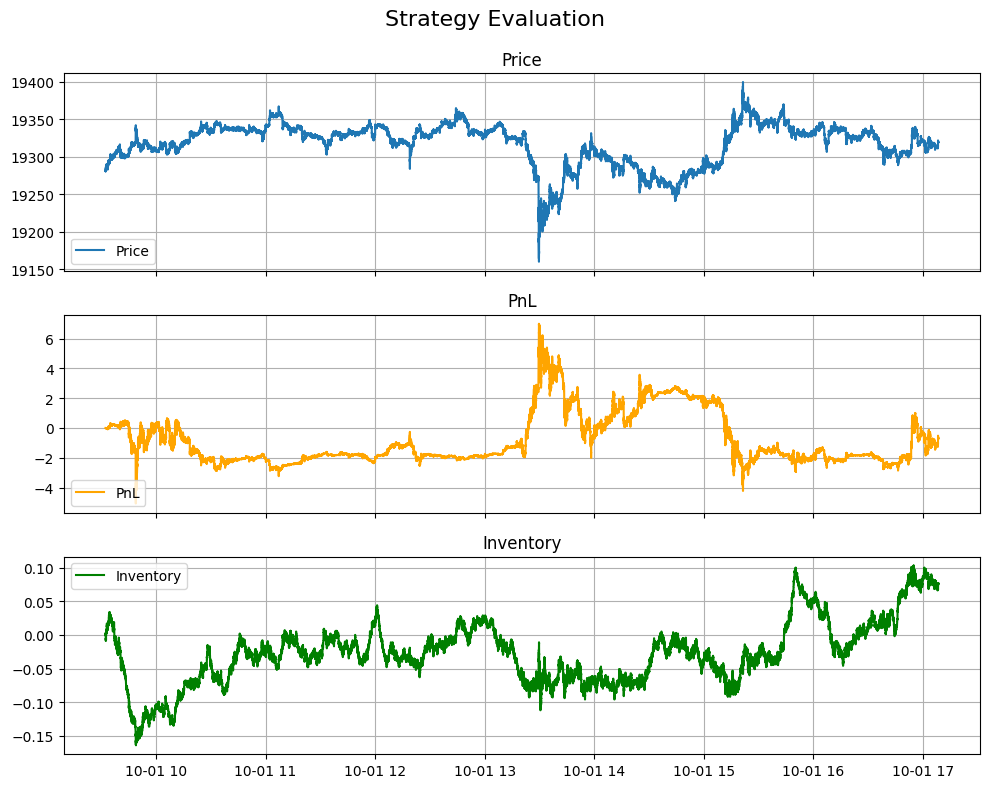

Mean Inventory: -0.0309 - Std: 0.0465 - Skew: 0.32


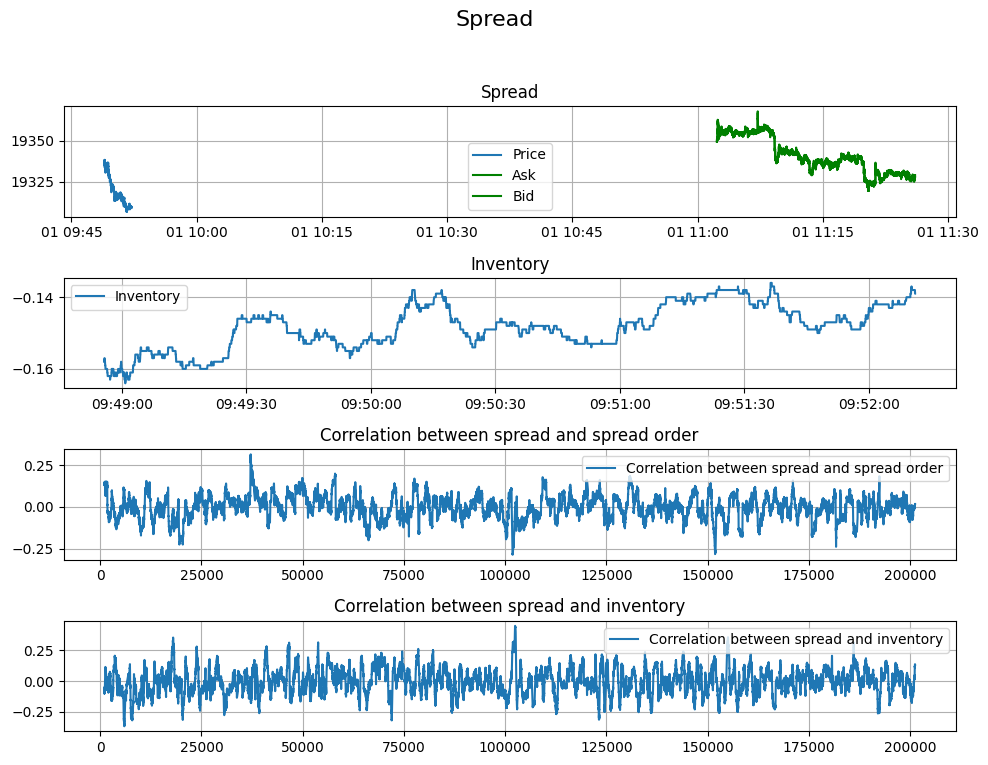

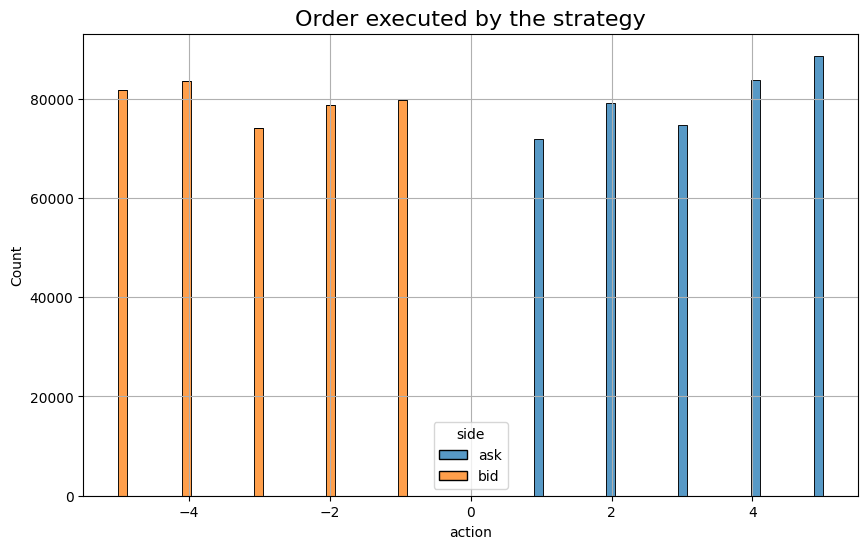

In [35]:
model = QLearning(
    alpha=MIN_ALPHA, 
    alpha_decay=ALPHA_DECAY,
    gamma=GAMMA,
    min_alpha=MIN_ALPHA
)
strategy_QL = RLStrategy(
    model=model,
    min_position=MIN_POSITION,
    max_position=MAX_POSITION,
    delay=INTERVAL_BTW_ORDERS,
    trade_size=TRADE_SIZE,
    maker_fee=MAKER_FEE,
    order_book_depth=ORDER_BOOK_DEPTH,
)
strategy_QL.load_q_table("model/ensemble_Qlearning_table.npy")
env = Real_Data_Env(market_event_val, EXECUTION_DELAY, MARKET_EVENT_DELAY)

trades, market_updates, orders, updates = strategy_QL.run(env, "test", 1500000)
evaluate_strategy(strategy_QL, trades, updates, orders)

## SARSA

Simulation runned for 90.60s                                                                                                                                                                            


c:\Users\artco\Downloads\RL - Market Making\utils\evaluate.py:143: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



Executed Trades: 50793
Mean PnL: -3.4071


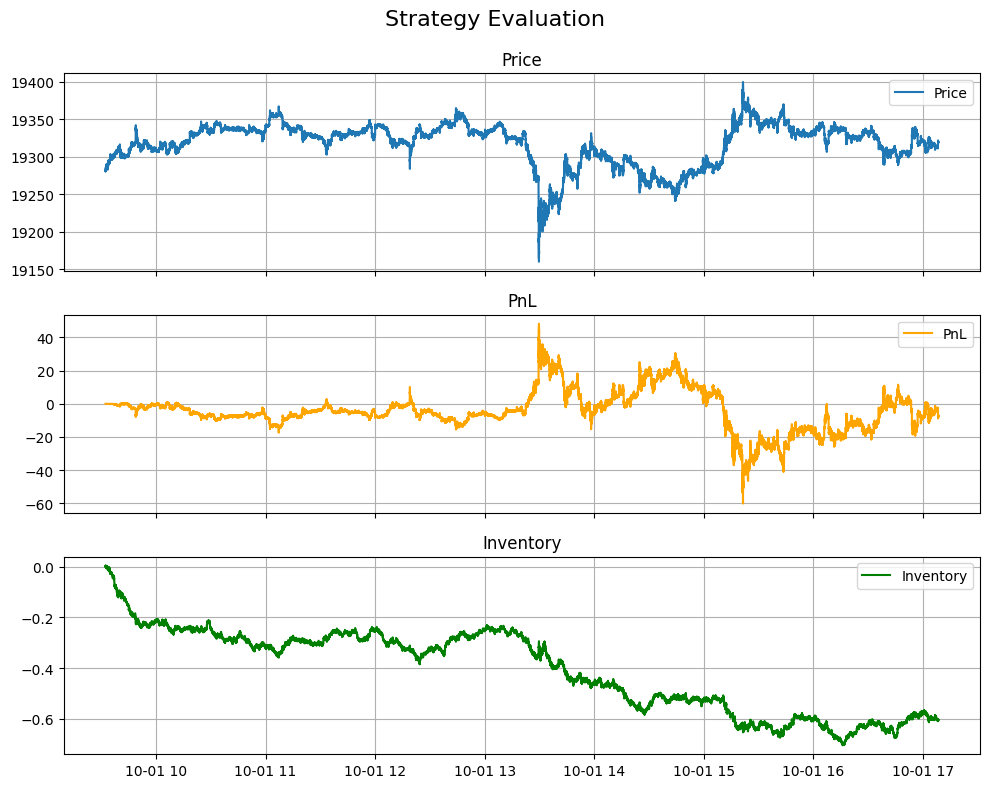

Mean Inventory: -0.4138 - Std: 0.1603 - Skew: -0.07


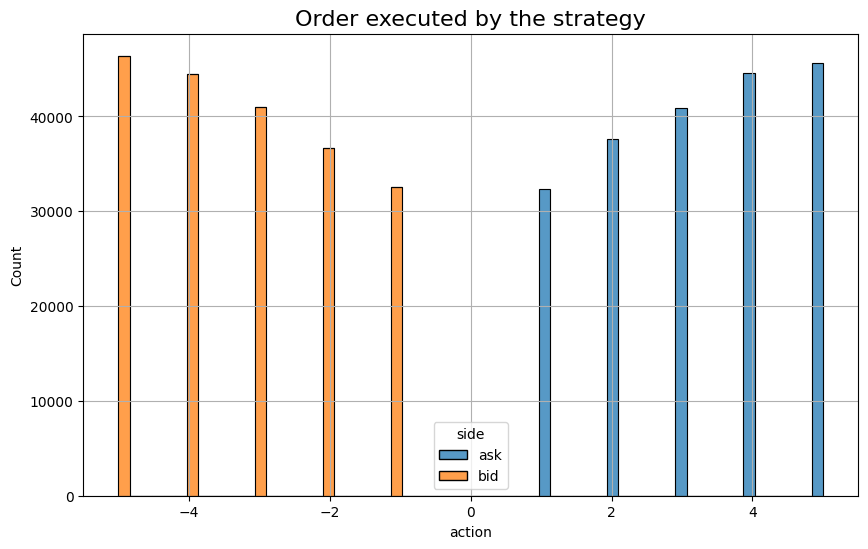

In [11]:
model = SARSA(
    alpha=MIN_ALPHA, 
    alpha_decay=ALPHA_DECAY,
    gamma=GAMMA,
    min_alpha=MIN_ALPHA
)
strategy_SARSA = RLStrategy(
    model=model,
    min_position=MIN_POSITION,
    max_position=MAX_POSITION,
    delay=INTERVAL_BTW_ORDERS,
    trade_size=TRADE_SIZE,
    maker_fee=MAKER_FEE,
    order_book_depth=ORDER_BOOK_DEPTH,
)
strategy_SARSA.load_q_table("model/ensemble_SARSA_table.npy")
env = Real_Data_Env(market_event_val, EXECUTION_DELAY, MARKET_EVENT_DELAY)

trades, market_updates, orders, updates = strategy_SARSA.run(env, "test", 1500000)
evaluate_strategy(strategy_SARSA, trades, updates, orders)

## Naive Strategy
At every moment place an order at the best bid and best ask price. When the inventory is at the limit place an order at the best bid or best ask price depending on the inventory position.

Simulation runned for 26.98s                                                                                                                                                                            


c:\Users\artco\Downloads\RL - Market Making\utils\evaluate.py:143: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



Executed Trades: 138864
Mean PnL: 2.7466


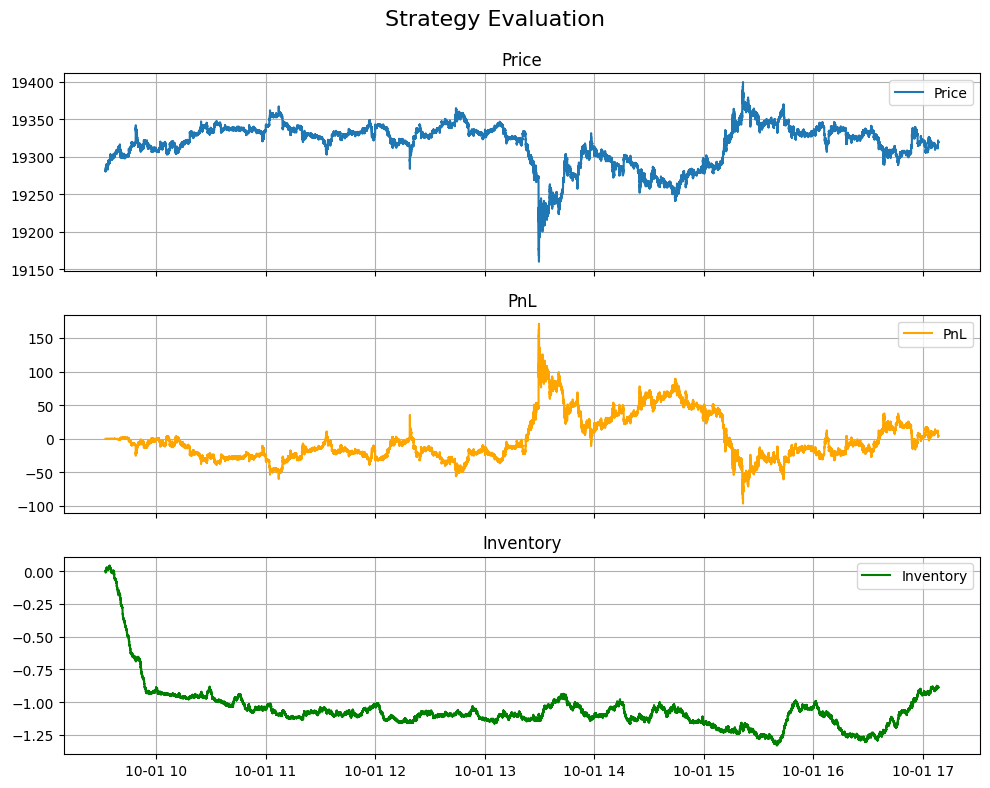

Mean Inventory: -1.0583 - Std: 0.1880 - Skew: 3.39
Trajectory not available


In [22]:
strategyBestPos = BestPosStrategy(
    min_position=MIN_POSITION,
    max_position=MAX_POSITION,
    delay=INTERVAL_BTW_ORDERS,
    trade_size=TRADE_SIZE,
    maker_fee=MAKER_FEE,
)
env = Real_Data_Env(market_event_val, EXECUTION_DELAY, MARKET_EVENT_DELAY)

trades, market_updates, orders, updates = strategyBestPos.run(env, 1500000)
evaluate_strategy(strategyBestPos, trades, updates, orders)

## Stoikov


Executed Trades: 34881
Mean PnL: -6.3840


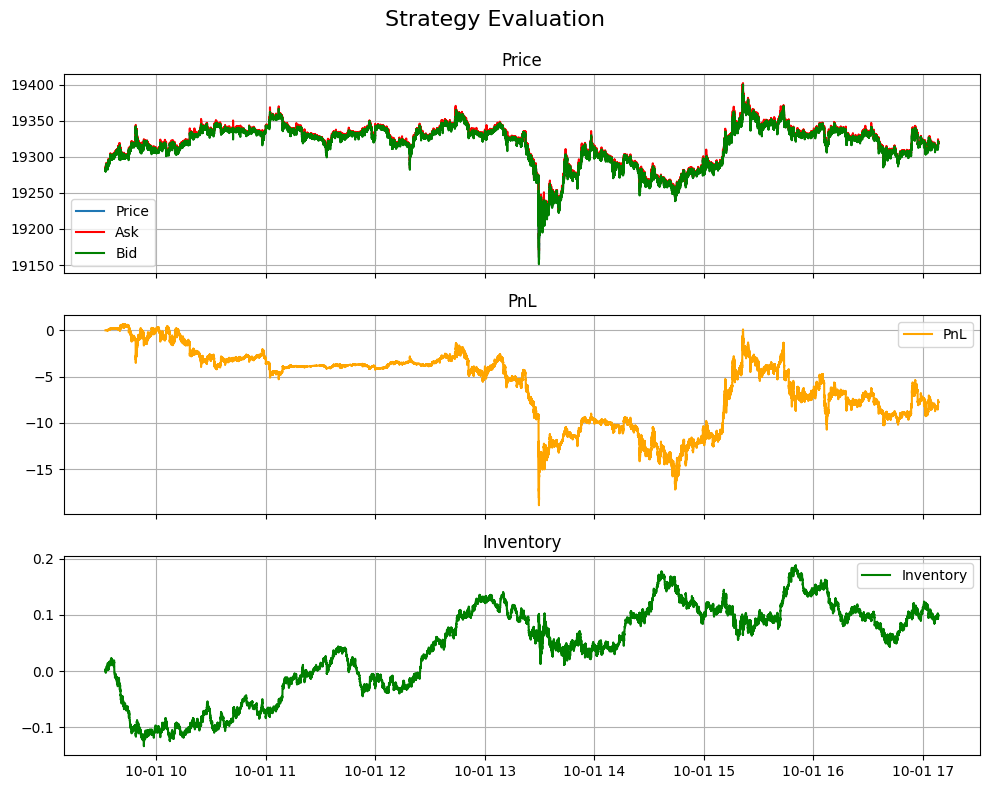

Mean Inventory: 0.0446 - Std: 0.0774 - Skew: -0.57


KeyError: "None of [DatetimeIndex(['2022-10-01 08:21:17.269999981',\n               '2022-10-01 08:21:17.296999931',\n               '2022-10-01 08:21:17.346999884',\n               '2022-10-01 08:21:17.381000042',\n               '2022-10-01 08:21:17.447000027',\n               '2022-10-01 08:21:17.546999931',\n               '2022-10-01 08:21:17.647000074',\n               '2022-10-01 08:21:17.663000107',\n               '2022-10-01 08:21:17.696000099',\n               '2022-10-01 08:21:17.696000099',\n               ...\n               '2022-10-01 08:25:34.868000031',\n               '2022-10-01 08:25:34.868000031',\n               '2022-10-01 08:25:34.868999958',\n               '2022-10-01 08:25:34.868999958',\n               '2022-10-01 08:25:34.868999958',\n               '2022-10-01 08:25:34.868999958',\n               '2022-10-01 08:25:34.878000021',\n               '2022-10-01 08:25:34.878000021',\n               '2022-10-01 08:25:34.878000021',\n               '2022-10-01 08:25:34.885999918'],\n              dtype='datetime64[ns]', name='exchange_ts', length=10000, freq=None)] are in the [index]"

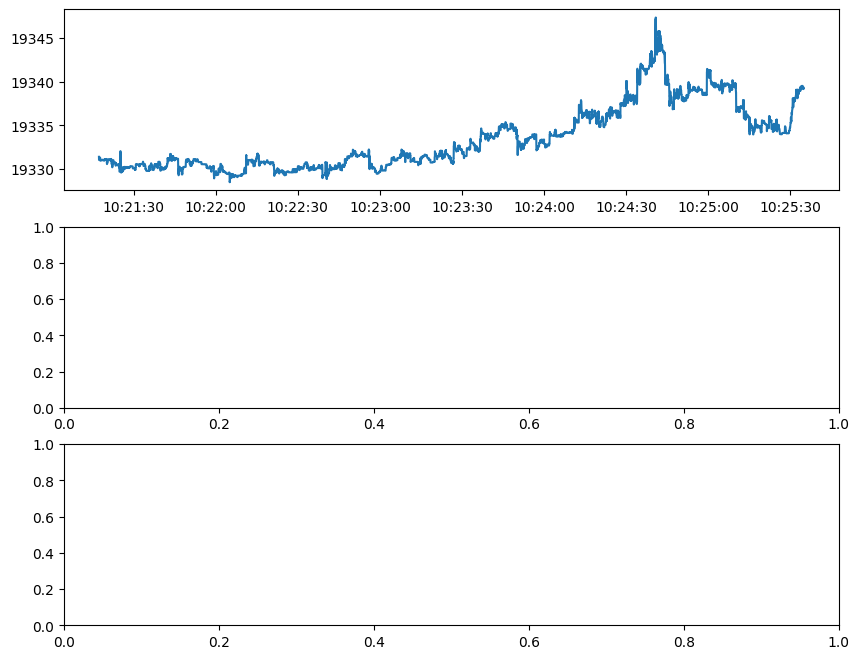

In [30]:
# strategyStoikov = StoikovStrategy(
#     delay=INTERVAL_BTW_ORDERS,
#     trade_size=TRADE_SIZE,
#     maker_fee=MAKER_FEE,
# )
# env = Real_Data_Env(market_event_val, EXECUTION_DELAY, MARKET_EVENT_DELAY)

# trades, market_updates, orders, updates = strategyStoikov.run(env, 1500000)
evaluate_strategy(strategyStoikov, trades, updates, orders)